# Regionalização de Bacias usando Redes Neurais

## Importing Packages

In [1]:
import sys
sys.path.append("..")
sys.path.append("../src")
sys.path.append("../database")
sys.path.append("../scripts")

In [2]:
import pandas as pd
import numpy as np
from funcoes_auxiliares import *
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_columns = 999

import warnings

warnings.filterwarnings('ignore')
#from funcoes_auxiliares import *
# # Plotting
# import plotly
# import plotly.graph_objs as go
# # import plotly.io as pio
# #import cufflinks as cf
# plotly.offline.init_notebook_mode(connected=True)


## Importing Data

In [4]:
dados = pd.read_csv("../database/Formated inputs/DadosFFN1.csv")


In [5]:
areas_corretas = {
    34730000: 1030,
    34740000: 528,
    36220000: 1570
}

In [6]:
MatrizCarac_EstFlu = pd.read_csv("../database/input/MatrizCarac_EstFlu.csv")
MatrizCarac_EstFlu= MatrizCarac_EstFlu.rename(columns={
    "Unnamed: 0":"EstANA"
})
print(len(MatrizCarac_EstFlu))
MatrizCarac_EstFlu.head()

38


,EstANA,Area_km2,Perimetro_km,CTD_km,Cristalino,Kc,DD_km_km2,CAD_mm,Declividade_%,CN_mm,Altitude_m,Prec_med_mm_ano,Lam_Esc_mm_ano
0,34730000,1069.562746,214.359244,626.923006,0.000000,1.848988,0.586149,59.476830,6.896018,76.792088,776.995550,857.054426,113.396630
1,34740000,2232.245764,363.582720,1373.708526,0.000003,2.170837,0.615393,55.469277,7.185813,76.860650,678.874399,714.306628,40.901406
2,35050000,1000.581633,225.583204,606.660753,0.435011,2.011757,0.606308,56.550239,9.201161,75.298776,169.104581,950.665979,100.021947
3,35125000,1583.019223,255.943097,1581.875993,0.925371,1.814661,0.999278,66.041300,7.983769,76.749403,191.982786,943.062311,138.607145
4,35170000,3961.056360,486.862283,3515.813294,0.771448,2.182206,0.887595,68.920900,8.160028,76.569628,238.610536,1089.931237,221.327359


In [7]:
caracFisicas = pd.read_excel("../database/input/dados.xls",sheet_name="Resultados")\
                            .drop(["SAT","PES","Nash","Nash Ver"],axis=1)

metadados_ANA = pd.read_excel("../database/input/metadados_ANA_EstFlu_CE_CPRM2020.xlsx")

db = pd.ExcelFile("../database/input/dados.xls")
basins = db.sheet_names[6:]

In [8]:
MatrizCarac_EstFlu.columns

Index(['EstANA', 'Area_km2', 'Perimetro_km', 'CTD_km', 'Cristalino', 'Kc',
       'DD_km_km2', 'CAD_mm', 'Declividade_%', 'CN_mm', 'Altitude_m',
       'Prec_med_mm_ano', 'Lam_Esc_mm_ano'],
      dtype='object')

In [9]:
new_names = {'Estações ANA': 'Estações ANA',
 'Declividade - D (%)': 'Declividade_%',
 'Precipitação média - P (mm)': 'Prec_med_mm_ano',
 'Comprimento do rio principal - CT (km)': 'CT_km',
 'Área de contribuição da estação fluviométrica - A (km2)': 'Area_km2',
 'Perímetro da área de contribuição da estação fluviométrica - P (km)': 'Perimetro_km',
 'Comprimento total de drenagem - CTD (km)': 'CTD_km',
 'Densidade de drenagem - DD (km-1)': 'DD_km_km2',
 'Capacidade de armazenamento do solo CAD (mm)': 'CAD_mm',
 'Curve number médio – CN (mm)': 'CN_mm',
 'Índice de compacidade da bacia - Kc': 'Kc',
 'Parcela da bacia no cristalino - Cr': 'Cristalino'}

In [10]:
new_names = {'Estações ANA': 'Estações ANA',
 'Declividade - D (%)': 'D',
 'Precipitação média - P (mm)': 'P_avg',
 'Comprimento do rio principal - CT (km)': 'CT',
 'Área de contribuição da estação fluviométrica - A (km2)': 'A',
 'Perímetro da área de contribuição da estação fluviométrica - P (km)': 'P',
 'Comprimento total de drenagem - CTD (km)': 'CTD',
 'Densidade de drenagem - DD (km-1)': 'DD',
 'Capacidade de armazenamento do solo CAD (mm)': 'CAD',
 'Curve number médio – CN (mm)': 'CN',
 'Índice de compacidade da bacia - Kc': 'Kc',
 'Parcela da bacia no cristalino - Cr': 'Cr'
}

In [11]:
{v:k for (k,v) in new_names.items()}
# list(new_names.items())[4]

{'Estações ANA': 'Estações ANA',
 'D': 'Declividade - D (%)',
 'P_avg': 'Precipitação média - P (mm)',
 'CT': 'Comprimento do rio principal - CT (km)',
 'A': 'Área de contribuição da estação fluviométrica - A (km2)',
 'P': 'Perímetro da área de contribuição da estação fluviométrica - P (km)',
 'CTD': 'Comprimento total de drenagem - CTD (km)',
 'DD': 'Densidade de drenagem - DD (km-1)',
 'CAD': 'Capacidade de armazenamento do solo CAD (mm)',
 'CN': 'Curve number médio – CN (mm)',
 'Kc': 'Índice de compacidade da bacia - Kc',
 'Cr': 'Parcela da bacia no cristalino - Cr'}

In [12]:
caracFisicas = caracFisicas.rename(columns=new_names)#.apply(lambda x:)


In [13]:
bacias = list(set(dados['Estações ANA']))
bacias.sort()


In [14]:
caracFisicas["Estações ANA"] == bacias

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
Name: Estações ANA, dtype: bool

In [15]:
Q_med = []
for bacia in bacias:
    idx = dados['Estações ANA'] == bacia
    Q_med.append(dados[idx].Q_0.mean())



In [16]:
caracFisicas['Q_avg'] = Q_med
bacias_com_problema = [34730000,34740000,36220000]

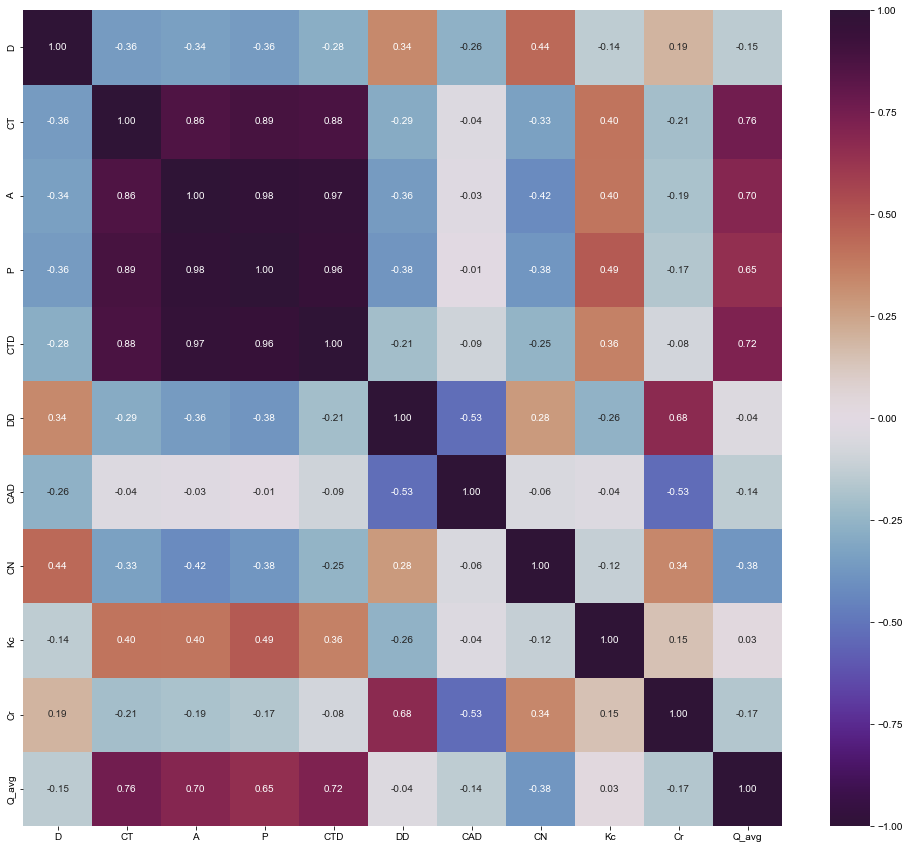

In [17]:
matriz_correlacao = caracFisicas.query(f"`Estações ANA` not in {bacias_com_problema}").drop(columns=["Estações ANA","P_avg"]).corr()

plt.figure(figsize=(17,15))
sns.heatmap(matriz_correlacao, 
            annot=True, 
            fmt=".2f",
            cmap="twilight_shifted",
            vmin=-1, vmax=1
           )
sns.set(font_scale=1.2)
# plt.title("Attributes Pearson correlation coefficient heatmap", fontdict={'fontsize':20})
plt.savefig("../database/output/Plots/ATT_AUROCORR_HEATMAP.png", dpi=300)

## Select k-best features

In [18]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

select_kbest = SelectKBest(f_regression, k = 6)

In [19]:
bacias_com_problema = [36220000]

In [20]:
DadosFFN1 = pd.read_csv("../database/input/DadosFFN1.csv").query(f"`Estações ANA` not in {bacias_com_problema}")
bacias = list(set(DadosFFN1['Estações ANA']))
bacias.sort()
DadosFFN1.head()

,Estações ANA,Declividade - D (%),Comprimento do rio principal - CT (km),Área de contribuição da estação fluviométrica - A (km2),Perímetro da área de contribuição da estação fluviométrica - P (km),Comprimento total de drenagem - CTD (km),Densidade de drenagem - DD (km-1),Curve number médio – CN (mm),Parcela da bacia no cristalino - Cr,E_0,P_2,P_1,P_0,Q_2,Q_1,Q_0
0,34730000,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.377420,0.333448,0.221624,0.233278,0.006548,0.005097,3.870129
1,34730000,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.432495,0.221624,0.233278,0.020416,0.005097,0.003214,2.136953
2,34730000,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.597038,0.233278,0.020416,0.004953,0.003214,0.001774,1.040503
3,34730000,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.767287,0.020416,0.004953,0.001582,0.001774,0.000864,0.629442
4,34730000,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.863514,0.004953,0.001582,0.003185,0.000864,0.000523,0.388273


In [21]:
drop_columns = ['Estações ANA',
#        'Declividade - D (%)',
#        'Comprimento do rio principal - CT (km)',
#        'Comprimento total de drenagem - CTD (km)',
#        'Perímetro da área de contribuição da estação fluviométrica - P (km)',
#        'Densidade de drenagem - DD (km-1)',
        'Q_2', 'Q_1', 'Q_0']

In [22]:
X = DadosFFN1.drop(drop_columns,axis=1)
Y = DadosFFN1['Q_0'].values


In [23]:
print(len(X))
X.head()

9164


,Declividade - D (%),Comprimento do rio principal - CT (km),Área de contribuição da estação fluviométrica - A (km2),Perímetro da área de contribuição da estação fluviométrica - P (km),Comprimento total de drenagem - CTD (km),Densidade de drenagem - DD (km-1),Curve number médio – CN (mm),Parcela da bacia no cristalino - Cr,E_0,P_2,P_1,P_0
0,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.377420,0.333448,0.221624,0.233278
1,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.432495,0.221624,0.233278,0.020416
2,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.597038,0.233278,0.020416,0.004953
3,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.767287,0.020416,0.004953,0.001582
4,0.574329,0.029281,0.019908,0.032449,0.011994,0.365241,0.0,0.0,0.863514,0.004953,0.001582,0.003185


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
     X, Y, test_size=0.33, random_state=42)

In [25]:
select_kbest.fit(X_train,y_train)
X_train_kbest = select_kbest.transform(X_train)
X_test_kbest = select_kbest.transform(X_test)

In [26]:
cols = select_kbest.get_support(indices=True)
X.columns[cols]


Index(['Comprimento do rio principal - CT (km)',
       'Área de contribuição da estação fluviométrica - A (km2)', 'E_0', 'P_2',
       'P_1', 'P_0'],
      dtype='object')

## RFE

In [27]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

In [28]:
from sklearn.metrics import make_scorer

nse = make_scorer(NASH)

In [29]:
estimator = SGDRegressor(random_state=1, max_iter=500)
#estimator = SVR(kernel="linear")
selecionador_rfe = RFE(estimator, n_features_to_select = 8, step=1)

selecionador_rfe.fit(X_train, y_train)
X_train_rfe = selecionador_rfe.transform(X_train)
X_test_rfe = selecionador_rfe.transform(X_test)

cols = selecionador_rfe.get_support(indices=True)
X.columns[cols]


Index(['Comprimento do rio principal - CT (km)',
       'Área de contribuição da estação fluviométrica - A (km2)',
       'Curve number médio – CN (mm)', 'Parcela da bacia no cristalino - Cr',
       'E_0', 'P_2', 'P_1', 'P_0'],
      dtype='object')

In [30]:
estimator = SGDRegressor(random_state=1, max_iter=500)
selecionador_rfe = RFECV(estimator,
                         min_features_to_select = 1,
#                          scoring = nse,
                         step=1)
selecionador_rfe.fit(X_train, y_train)
X_train_rfe = selecionador_rfe.transform(X_train)
X_test_rfe = selecionador_rfe.transform(X_test)

cols = selecionador_rfe.get_support(indices=True)
X.columns[cols]

Index(['Comprimento do rio principal - CT (km)',
       'Área de contribuição da estação fluviométrica - A (km2)',
       'Comprimento total de drenagem - CTD (km)',
       'Curve number médio – CN (mm)', 'Parcela da bacia no cristalino - Cr',
       'E_0', 'P_2', 'P_1', 'P_0'],
      dtype='object')

[Text(0.5, 0, 'Number of features selected'),
 Text(0, 0.5, 'NSE'),
 Text(0.5, 1.0, 'Recursive feature elimination with cross-validation')]

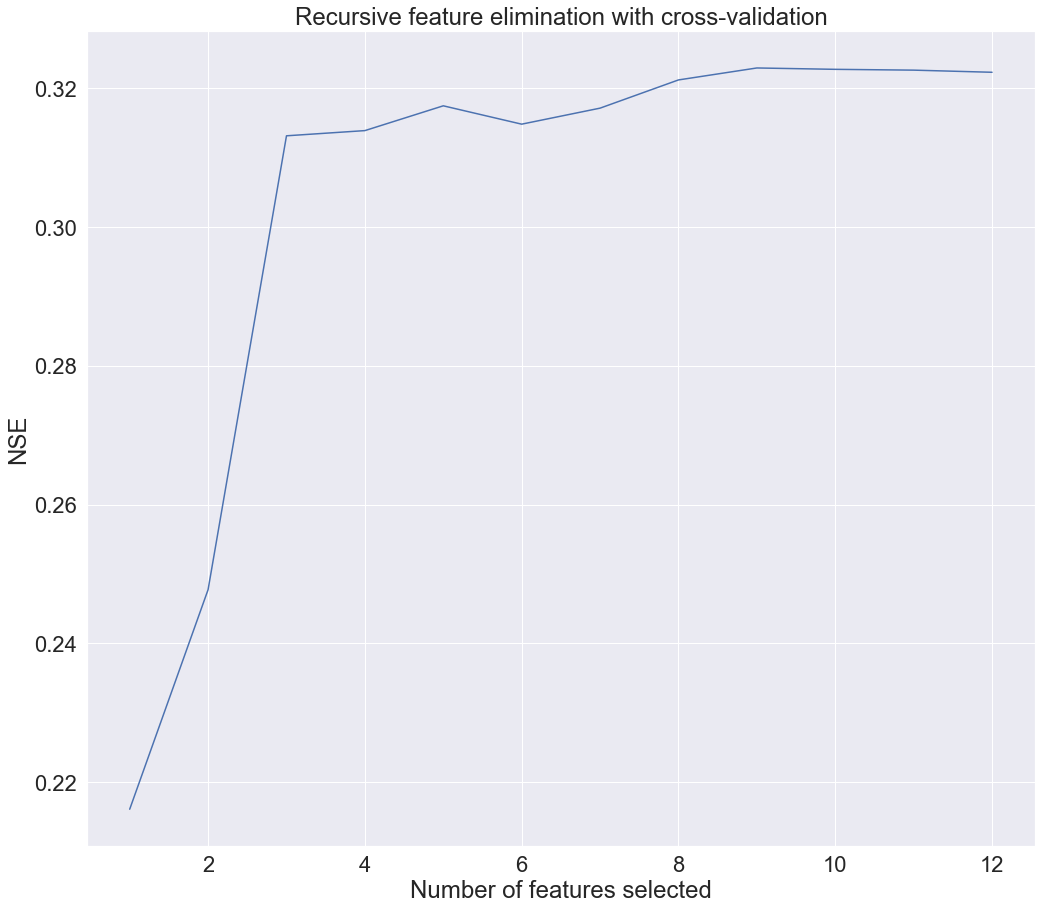

In [31]:
plt.figure(figsize=(17,15))

sns.set_color_codes("dark")

sns.set_style("darkgrid", 
#               {"axes.facecolor": ".9"}
             )
sns.set(font_scale=2)
sns.lineplot(x=range(1,
               len(selecionador_rfe.grid_scores_) + 1),
             y=selecionador_rfe.grid_scores_[:,0],
             color='b'
            ).set(xlabel='Number of features selected', 
                  ylabel='NSE', title='Recursive feature elimination with cross-validation')
# plt.savefig("../database/output/RFE_SGDRegressor.png", dpi=300)

In [32]:
# X.shape[1] > 
len(cols)

9

In [33]:
print(X.columns[cols])

Index(['Comprimento do rio principal - CT (km)',
       'Área de contribuição da estação fluviométrica - A (km2)',
       'Comprimento total de drenagem - CTD (km)',
       'Curve number médio – CN (mm)', 'Parcela da bacia no cristalino - Cr',
       'E_0', 'P_2', 'P_1', 'P_0'],
      dtype='object')
